In [485]:
import pandas as pd
import requests
import json
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

### CSV SOURCE

In [470]:
policies = pd.read_csv('police_policies.csv',skiprows = [1]).fillna(0)

### HTML SOURCE

In [322]:
url = 'https://www.icpsr.umich.edu/files/NACJD/ORIs/STATESoris.html'
def getSoup(url):
    r = requests.get(url)
    if r.status_code == 200:
        print('Connected')
    else:
        print('Sorry could not reach the web page!')
    html = r.text
    soup = BeautifulSoup(html)
    return soup

In [100]:
states = ['01','02','04','05','06','08','09']
for i in np.arange(10,57):
    states.append(str(i))
states = states[:11] + states[12:40] + states[41:49] + states[50:] # The website had weird numberings so had to match

In [323]:
url = 'https://www.icpsr.umich.edu/files/NACJD/ORIs/01oris.html#01_AUTAUGA_(FIPS=001_UCR=001)'
pre = getSoup(url).find_all('pre')

Connected


In [362]:
def cleanPreSoup(pre):    
    tryit = pd.DataFrame(str(pre).split('  '))
    try2 = tryit.replace(to_replace='',value = np.nan)
    tried = try2.dropna(axis=0)
    datalist = []
    for r in tried[0]:
        if len(r) >=6:
            datalist.append(r)
    fulllist = []
    remove = re.compile('<pre>\nCITY/AGENCY|\n</pre>, <pre>\nCITY/AGENCY|</pre>]')
    for r in datalist:
        if re.search(remove,r):
            continue
        else: fulllist.append(r)    
    clean = []
    for r in fulllist:
        if r.startswith(' \n\n'):
            clean.append(r[4:])
        elif r.startswith('\n\n'):
            clean.append(r[3:])   
        elif r.startswith('\n'):
            clean.append(r[1:])
        else: clean.append(r.strip())
    return clean
        

def tryint(var):
    try:
        x = int(var[3])
        return True
    except ValueError:
        return False 
    except IndexError:
        return False 
    
def sortClean(clean):
    ori7 = []
    ori9 = []
    names = []
    for r in clean:
        if tryint(r)== True and len(r) <9:
            ori7.append(r)
        elif tryint(r)== True and len(r) <10:
            ori9.append(r)
        else: names.append(r)
    return names, ori7, ori9              

In [364]:
namesoris = pd.DataFrame()
count = 0
countycount = 0 
for s in states:
    surl = 'https://www.icpsr.umich.edu/files/NACJD/ORIs/' + s + 'oris.html'
    count += 1
    print('State #:',count)
    for d in getSoup(surl).find_all('pre'):
        data = cleanPreSoup(d)
        namesoris = pd.concat([namesoris,pd.DataFrame(sortClean(data)).T])

State #: 1
Connected
State #: 2
Connected
State #: 3
Connected
State #: 4
Connected
State #: 5
Connected
State #: 6
Connected
State #: 7
Connected
State #: 8
Connected
State #: 9
Connected
State #: 10
Connected
State #: 11
Connected
State #: 12
Connected
State #: 13
Connected
State #: 14
Connected
State #: 15
Connected
State #: 16
Connected
State #: 17
Connected
State #: 18
Connected
State #: 19
Connected
State #: 20
Connected
State #: 21
Connected
State #: 22
Connected
State #: 23
Connected
State #: 24
Connected
State #: 25
Connected
State #: 26
Connected
State #: 27
Connected
State #: 28
Connected
State #: 29
Connected
State #: 30
Connected
State #: 31
Connected
State #: 32
Connected
State #: 33
Connected
State #: 34
Connected
State #: 35
Connected
State #: 36
Connected
State #: 37
Connected
State #: 38
Connected
State #: 39
Connected
State #: 40
Connected
State #: 41
Connected
State #: 42
Connected
State #: 43
Connected
State #: 44
Connected
State #: 45
Connected
State #: 46
Connect

In [463]:
newdata = namesoris.dropna(axis = 0).drop_duplicates().rename(columns = {0:'name',
                                                                         1:'ori7',
                                                                         2:'ori'})
newdata

,name,ori7,ori
0,UTAUGA COUNTY SHERIFF'S OFFICE,AL00400,AL0040000
1,AUTAUGAVILLE POLICE DEPARTMENT,AL00402,AL0040200
2,PRATTVILLE POLICE DEPARTMENT,AL00401,AL0040100
0,ALDWIN COUNTY SHERIFF'S OFFICE,AL00500,AL0050000
1,BAY MINETTE POLICE DEPARTMENT,AL00501,AL0050100
...,...,...,...
0,ASHAKIE COUNTY SHERIFF'S OFFICE,WY02200,WY0220000
1,WORLAND POLICE DEPARTMENT,WY02201,WY0220100
0,EWCASTLE POLICE DEPT,WY02301,WY0230100
1,UPTON POLICE DEPARTMENT,WY02302,WY0230200


### API SOURCE

In [370]:
APIkey = 'gsw6K5NlnQJ5BzYDkuRYu1RQyk7kPOlYoB79w1UQ'
APIbaseURL = 'https://api.usa.gov/crime/fbi/sapi'
fbicdetest = requests.get(APIbaseURL +'/api/data/arrest/national/offense/all/2017/2018?API_KEY=' + APIkey)

In [371]:
j = fbicdetest.json()

In [372]:
fbi = pd.DataFrame(j['results'])
fbi.drop(columns='csv_header')

,aggravated_assault,all_other_offenses,arson,burglary,curfew,disorderly,driving,drug_abuse_gt,drug_poss_m,drug_poss_opium,...,rape,robbery,sex_offense,simple_assault,stolen_property,suspicion,vagrancy,vandalism,weapons,data_year
0,342593,3039334,7745,180460,24414,291377,835885,1474525,505188,264030,...,21944,83337,42069,957405,82932,734,18896,162378,140664,2017
1,324056,2708654,7541,148488,17605,271253,793552,1352038,497093,263628,...,20659,72697,38204,878930,78788,447,18581,148826,137808,2018


In [436]:
agencies = requests.get(APIbaseURL +'/api/summarized/state/AL/violent-crime/2017/2018?API_KEY=' + APIkey)
js = agencies.json()

In [437]:
fulldb = pd.DataFrame(js['results'])

In [438]:
states = ["AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "GA", "FL", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
for state in states:
    agencies = requests.get(APIbaseURL +'/api/summarized/state/' + state + '/violent-crime/2017/2017?API_KEY=' + APIkey)
    js = agencies.json()
    fulldb = pd.concat([fulldb,pd.DataFrame(js['results'])])

In [439]:
#Data per Org ID for all 50 states.
fulldb

,ori,data_year,offense,state_abbr,cleared,actual
0,AL0010000,2017,violent-crime,AL,234,700
1,AL0010100,2017,violent-crime,AL,12,787
2,AL0010200,2017,violent-crime,AL,446,2415
3,AL0010300,2017,violent-crime,AL,6,10
4,AL0010400,2017,violent-crime,AL,50,205
...,...,...,...,...,...,...
15,WY0060300,2017,violent-crime,WY,3,3
16,WY0070000,2017,violent-crime,WY,11,16
17,WY0070100,2017,violent-crime,WY,0,0
18,WY0070200,2017,violent-crime,WY,20,35


In [440]:
data = fulldb.rename(columns = {'ori':'org_id'})

In [441]:
agencystart = requests.get(APIbaseURL + '/api/summarized/agencies/' + 'FL0010000' + '/offenses/2017/2017?API_KEY=' + APIkey)
js = agencystart.json()
agencyspecificdb = pd.DataFrame(js['results'])

In [442]:
for org_id in data.org_id:
    agencyspecific = requests.get(APIbaseURL + '/api/summarized/agencies/' + org_id + '/offenses/2017/2017?API_KEY=' + APIkey)
    if agencyspecific.status_code == 200:
        print(org_id,' Connected')
        js = agencyspecific.json()
        agencyspecificdb = pd.concat([agencyspecificdb,pd.DataFrame(js['results'])])
    else:
        print(org_id, 'Sorry could not reach the web page!')

AL0010000  Connected
AL0010100  Connected
AL0010200  Connected
AL0010300  Connected
AL0010400  Connected
AL0010500  Connected
AL0010600  Connected
AL0010700  Connected
AL0010800  Connected
AL0010900  Connected
AL0011000  Connected
AL0011100  Connected
AL0011200  Connected
AL0011300  Connected
AL0011400  Connected
AL0011900  Connected
AL0012000  Connected
AL0012100  Connected
AL0012200  Connected
AL0012300  Connected
AK0010100  Connected
AK0010200  Connected
AK0010300  Connected
AK0010400  Connected
AK0010500  Connected
AK0010600  Connected
AK0010700  Connected
AK0010800  Connected
AK0010900  Connected
AK0011000  Connected
AK0011100  Connected
AK0011200  Connected
AK0011300  Connected
AK0011400  Connected
AK0011600  Connected
AK0011700  Connected
AK0011800  Connected
AK0012000  Connected
AK0012100  Connected
AK0012200  Connected
AZ0010000  Connected
AZ0010100  Connected
AZ0010300  Connected
AZ0010500  Connected
AZ0018900  Connected
AZ0020000  Connected
AZ0020500  Connected
AZ0020900  Co

MA0010600  Connected
MA0010700  Connected
MA0010800  Connected
MA0010900  Connected
MA0011000  Connected
MA0011100  Connected
MA0011200  Connected
MA0011300  Connected
MA0011400  Connected
MA0011500  Connected
MA0020100  Connected
MA0020300  Connected
MA0020400  Connected
MA0020600  Connected
MA0020900  Connected
MI0100100  Connected
MI0110100  Connected
MI0200200  Connected
MI0210200  Connected
MI0260200  Connected
MI0300300  Connected
MI0310300  Connected
MI0321000  Connected
MI0335300  Connected
MI0339200  Connected
MI0347800  Connected
MI0364100  Connected
MI0367000  Connected
MI0381100  Connected
MI0400400  Connected
MI0410400  Connected
MI0421500  Connected
MI0500500  Connected
MI0510500  Connected
MI0524500  Connected
MN0010000  Connected
MN0010100  Connected
MN0010400  Connected
MN0020000  Connected
MN0020100  Connected
MN0020200  Connected
MN0020300  Connected
MN0020400  Connected
MN0020500  Connected
MN0020600  Connected
MN0020700  Connected
MN0020800  Connected
MN0021300  Co

SC0020800  Connected
SC0021000  Connected
SC0021500  Connected
SC002SP00  Connected
SC0030100  Connected
SC0040000  Connected
SC0040100  Connected
SC0040200  Connected
SD0010000  Connected
SD0020000  Connected
SD0020100  Connected
SD0030000  Connected
SD0030100  Connected
SD0040000  Connected
SD0050000  Connected
SD0050100  Connected
SD005UN00  Connected
SD0060000  Connected
SD0060100  Connected
SD0070000  Connected
SD0070100  Connected
SD0080100  Connected
SD0090000  Connected
SD0090100  Connected
SD0100000  Connected
SD0110000  Connected
SD0110300  Connected
SD0120000  Connected
TN0010000  Connected
TN0010100  Connected
TN0010200  Connected
TN0010300  Connected
TN0010400  Connected
TN0010600  Connected
TN0010800  Connected
TN0020000  Connected
TN0020100  Connected
TN0020200  Connected
TN0030000  Connected
TN0030100  Connected
TN0030200  Connected
TN0030300  Connected
TN0040000  Connected
TN0040100  Connected
TN0040200  Connected
TN0050000  Connected
TN0050100  Connected
TN0050200  Co

In [460]:
workingdata = agencyspecificdb.reset_index().drop(columns = 'index').drop_duplicates()

In [461]:
depfbidata = workingdata.pivot_table(index = 'ori', columns = 'offense',values = ['cleared','actual'])

# Joining Data

In [466]:
fbi_names = pd.merge(depfbidata, newdata, how='left', on='ori')

/Users/annagoins/PycharmProjects/540/venv/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [472]:
fbi_names.head()

,ori,"(actual, aggravated-assault)","(actual, arson)","(actual, burglary)","(actual, homicide)","(actual, human-trafficing)","(actual, larceny)","(actual, motor-vehicle-theft)","(actual, property-crime)","(actual, rape)",...,"(cleared, human-trafficing)","(cleared, larceny)","(cleared, motor-vehicle-theft)","(cleared, property-crime)","(cleared, rape)","(cleared, rape-legacy)","(cleared, robbery)","(cleared, violent-crime)",name,ori7
0,AK0010100,2368,62,2216,27,0,10721,3104,16041,607,...,0,1358,497,2105,58,0,216,1650,ALCOHOL BEV CONTROL BRD,AK00101
1,AK0010200,131,6,164,10,0,1121,208,1493,24,...,0,299,44,370,4,0,12,85,FAIRBANKS POLICE DEPT.,AK00102
2,AK0010300,206,8,326,1,0,1262,95,1683,50,...,0,332,22,449,16,0,32,212,UNEAU POLICE DEPT.,AK00103
3,AK0010400,14,0,25,1,0,298,18,341,19,...,0,43,1,54,2,0,0,14,ETCHIKAN POLICE DEPT.,AK00104
4,AK0010500,41,0,20,0,0,180,11,211,15,...,0,18,3,24,4,0,2,24,ODIAK POLICE DEPT.,AK00105


Unfortunately the csv data that includes the policies of the police departments only include the name of the City and does not specifically reference the name of the police department making it difficult to confirm the validity of the matches. Additionally Few potential candidates are available based on the City name and the resulting data wouldn;t be useful to compare.

In [476]:
conn = sqlite3.connect('Final.db')
c = conn.cursor()

In [477]:
depfbidata.to_sql('fbi', conn)

/Users/annagoins/PycharmProjects/540/venv/lib/python3.7/site-packages/pandas/core/generic.py:2663: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [478]:
newdata.to_sql('names', conn)

In [483]:
finalset = pd.read_sql_query("""SELECT * FROM fbi
                                JOIN names on fbi.ori = names.ori""",conn)

In [484]:
finalset

,ori,"('actual', 'aggravated-assault')","('actual', 'arson')","('actual', 'burglary')","('actual', 'homicide')","('actual', 'human-trafficing')","('actual', 'larceny')","('actual', 'motor-vehicle-theft')","('actual', 'property-crime')","('actual', 'rape')",...,"('cleared', 'motor-vehicle-theft')","('cleared', 'property-crime')","('cleared', 'rape')","('cleared', 'rape-legacy')","('cleared', 'robbery')","('cleared', 'violent-crime')",index,name,ori7,ori
0,AL0012200,17,1,42,1,0,204,15,261,1,...,2,94,0,0,2,8,0,DAMSVILLE POLICE DEPARTMENT,AL00122,AL0012200
1,AL0010100,635,8,495,10,0,1867,219,2581,25,...,4,22,1,0,7,12,1,BESSEMER POLICE DEPARTMENT,AL00101,AL0010100
2,AL0010200,1625,140,1744,59,0,6026,1114,8884,120,...,176,562,5,0,122,446,2,BIRMINGHAM POLICE DEPARTMENT,AL00102,AL0010200
3,AL0010400,115,6,193,8,0,445,100,738,8,...,13,96,1,0,19,50,6,FAIRFIELD POLICE DEPARTMENT,AL00104,AL0010400
4,AL0011100,38,2,40,0,0,315,26,381,3,...,2,97,2,0,4,21,8,FULTONDALE POLICE DEPARTMENT,AL00111,AL0011100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,WY0060100,1,0,2,0,0,0,0,2,0,...,0,1,0,0,0,1,3,SUNDANCE POLICE DEPARTMENT,WY00601,WY0060100
936,WY0070000,12,0,25,0,0,153,13,191,4,...,7,107,0,0,0,11,1,FREMONT COUNTY SHERIFF'S OFFICE,WY00700,WY0070000
937,WY0070100,0,0,8,0,0,199,8,215,0,...,1,67,0,0,0,0,2,LANDER POLICE DEPARTMENT,WY00701,WY0070100
938,WY0070200,25,1,41,1,0,467,28,536,4,...,9,214,3,0,1,20,3,RIVERTON POLICE DEPARTMENT,WY00702,WY0070200


Text(0.5, 1.0, 'Aggravated Assault vs Larceny')

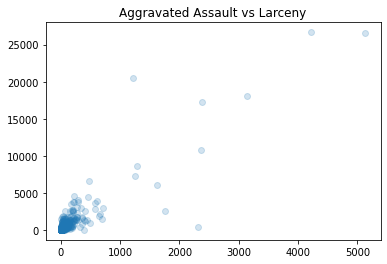

In [490]:
plt.scatter(finalset["""('actual', 'aggravated-assault')"""],finalset["""('actual', 'larceny')"""],alpha =.2)
plt.title('Aggravated Assault vs Larceny')

# Visualizing

Text(0.5, 1.0, 'Distribution of Aggravated Assault(Actual)')

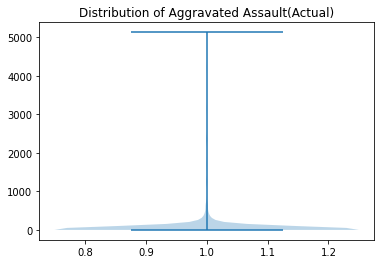

In [497]:
plt.violinplot(finalset["""('actual', 'aggravated-assault')"""])
plt.title('Distribution of Aggravated Assault(Actual)')

In [503]:
top10hom = finalset.sort_values("""('actual', 'homicide')""",ascending=False).head(10)

In [508]:
z = top10hom["""('actual', 'homicide')"""]
y = top10hom["""('cleared', 'homicide')"""]
text = np.arange(1,11)

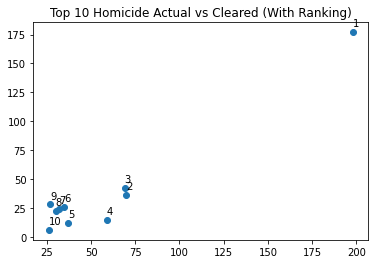

In [514]:
fig, ax = plt.subplots()
ax.scatter(z, y)
plt.title('Top 10 Homicide Actual vs Cleared (With Ranking)')
for i, txt in enumerate(text):
    ax.annotate(txt, (z.iloc[i], y.iloc[i]), (z.iloc[i], y.iloc[i]+5))

In [515]:
top3hom = finalset.sort_values("""('actual', 'homicide')""",ascending=False).head(3)

In [516]:
z = top3hom["""('actual', 'homicide')"""]
y = top3hom["""('cleared', 'homicide')"""]
text = top3hom['name']

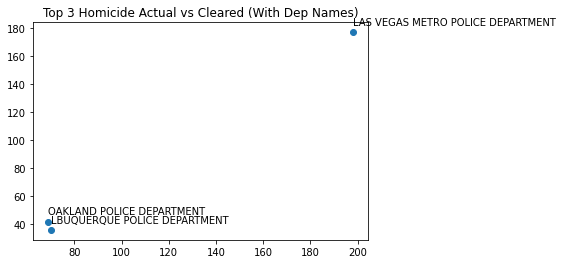

In [518]:
fig, ax = plt.subplots()
ax.scatter(z, y)
plt.title('Top 3 Homicide Actual vs Cleared (With Dep Names)')
for i, txt in enumerate(text):
    ax.annotate(txt, (z.iloc[i], y.iloc[i]), (z.iloc[i], y.iloc[i]+5))

In [535]:
checkcorrelation = pd.DataFrame(finalset["""('actual', 'aggravated-assault')"""])
genlist = []
for val in finalset['name'].values: 
    genlist.append(len(val))
checkcorrelation['name_length'] = genlist
x = checkcorrelation["""('actual', 'aggravated-assault')"""]
y = checkcorrelation['name_length']
#plt.title('Actual vs Cleared (Aggravated assault)')

Text(0.5, 1.0, 'Actual Aggravated Assault vs Length of Department Name')

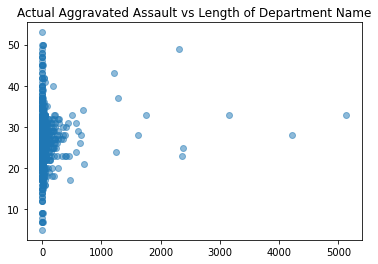

In [538]:
plt.scatter(x,y,alpha = .5)
plt.title('Actual Aggravated Assault vs Length of Department Name')